In [1]:
!nvidia-smi

Thu Mar 24 20:42:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
import os
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import random_split, Subset
from torch.utils.data.dataloader import DataLoader
from torch.autograd import Variable
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_to_data_nico = "/content/drive/My Drive/Master Big Data /Tesis Big Data/Dataset_Facturas/Facturas_Corregidas_Subset"

In [4]:
#Carpetas a analizar
folders_to_process = ["La Comercial SRL","Modadol","Fernando Garcia","Ayala","Antilur","La Banderita","Los Nietitos","Marioni","Masula"]

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
import random
# Load images from train folder
transf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
dataset = ImageFolder(path_to_data_nico, transform=transf)

indexes = random.sample(range(len(dataset)), len(dataset))
indexes_train = indexes[:int(len(dataset)*0.85)]
indexes_test = indexes[int(len(dataset)*0.85):]

test_set = Subset(dataset, indexes_test) 
train_set = Subset(dataset, indexes_train)

In [7]:
# Count images for each target class
TARGET_CLASSES = folders_to_process

print("Count images for each target class in the dataset: \n")
for target_class in TARGET_CLASSES:
    class_count = len(os.listdir(os.path.join(path_to_data_nico, target_class)))
    print(f"{target_class}: {class_count} images")

Count images for each target class in the dataset: 

La Comercial SRL: 19 images
Modadol: 7 images
Fernando Garcia: 11 images
Ayala: 7 images
Antilur: 212 images
La Banderita: 292 images
Los Nietitos: 3206 images
Marioni: 656 images
Masula: 52 images


In [8]:
BATCH_SIZE = 8
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

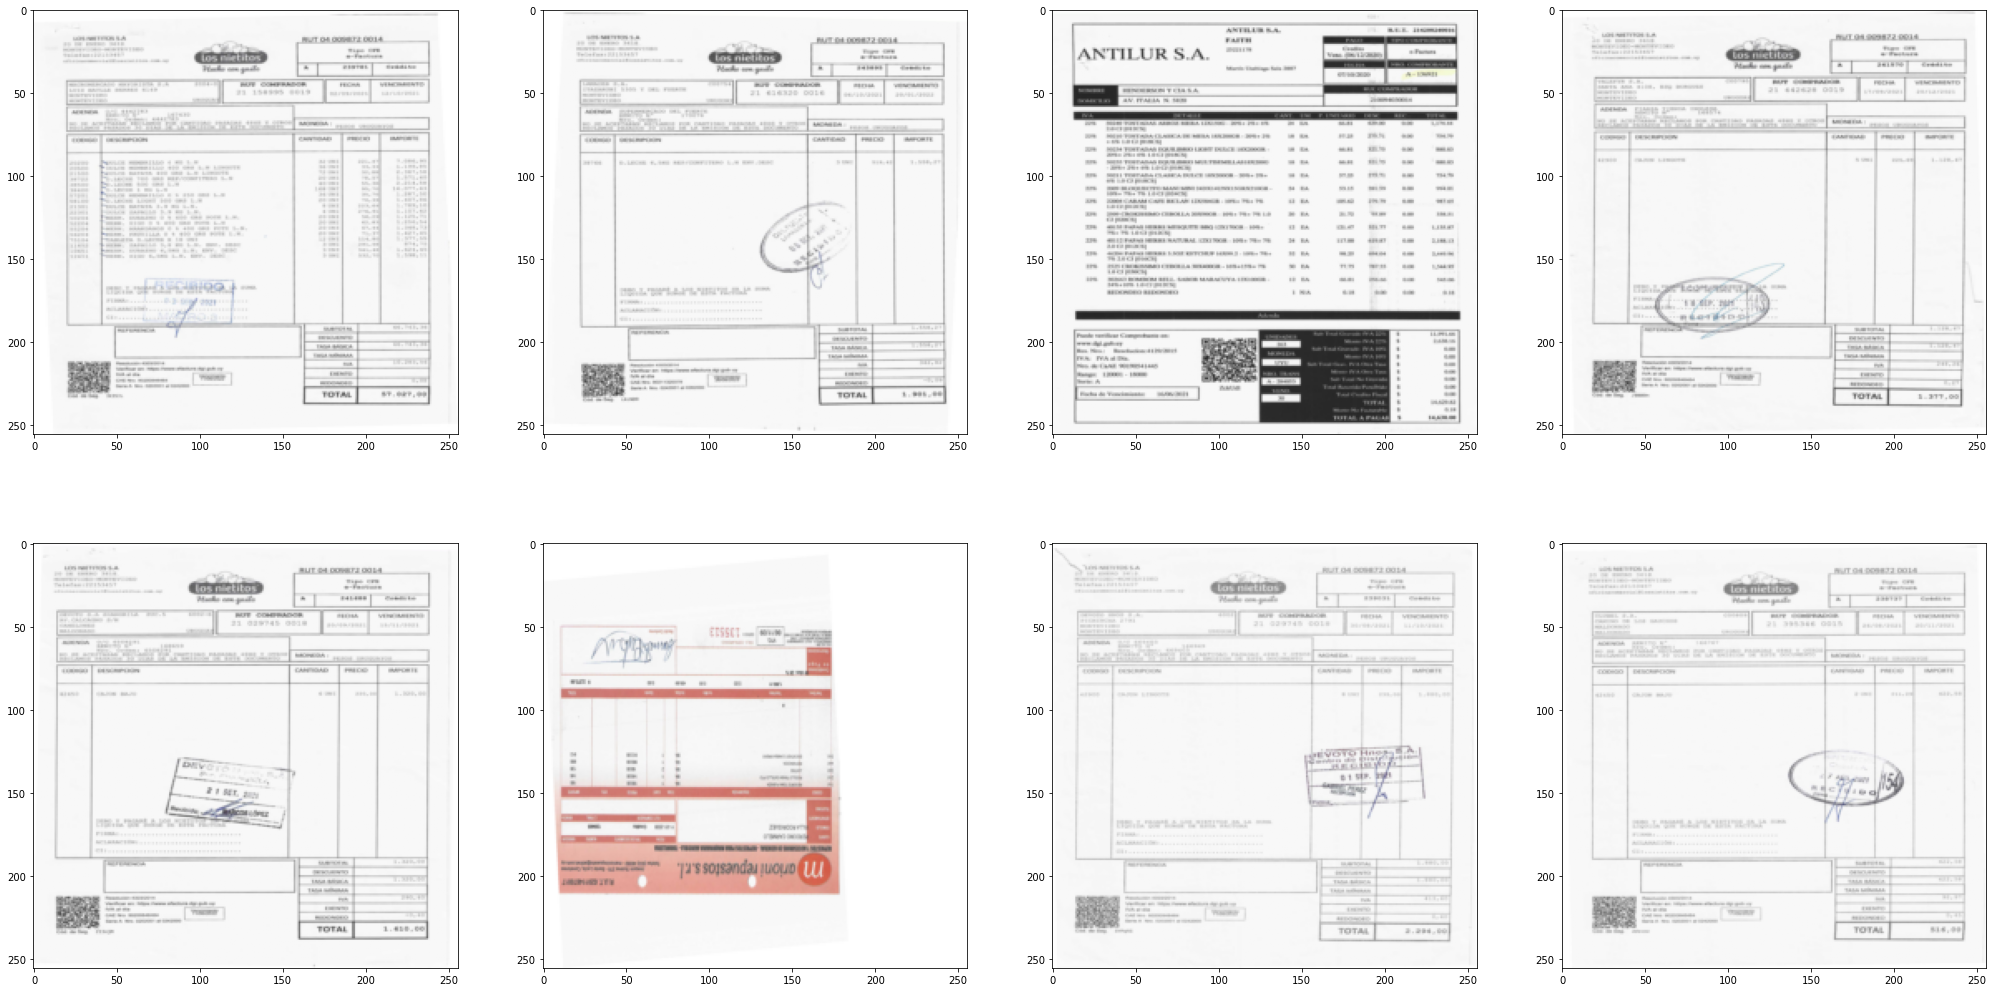

In [9]:
example_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
examples = enumerate(example_loader)

batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(35, 18))
for i in range(BATCH_SIZE):
  image = example_data[i]
  image = image.numpy().transpose((1, 2, 0))
  image = np.clip(image, 0, 1)
  plt.subplot(2, 4, i+1)
  plt.imshow(image)

In [10]:
# Input:
#        - training_model: neural net to train.
#        - loader: DataLoader with training data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - average loss of the epoch
#        - % of accuracy score
#        - % of precission score
#        - % of recall score
#        - % of F1 score
#
# Apart from metrics, for each training epoch I will track cumulative loss in order to plot loss evolution
def train_epoch(training_model, loader, criterion, optim):
    # set model to train state
    training_model.train()
    
    epoch_loss = 0.0
    
    # save 'y' and 'y_hat' for each image prediction
    all_labels = []
    all_predictions = []

    for images, labels in loader:
        # add mini-batch targets (tensor to list) to the end of 'all_labels' list
        all_labels.extend(labels.numpy())

        # reset gradients
        optim.zero_grad()

        # predict and save result to 'all_predictions' list
        # mini-batch images are mounted to the GPU
        predictions = training_model(images.to(device))
        
        # using cpu to get the class with highest value returned by the net
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        # mount labels to GPU and calculate loss comparing them with model predictions
        loss = criterion(predictions, labels.to(device))
        loss.backward()
        
        # Backprop, compute gradients and update model parameters
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [11]:
# Input:
#        - model: neural net to train.
#        - train_loader: DataLoader with train data.
#        - validation_loader: DataLoader with validation data.
#        - criterion: loss function.
#        - optim: optimizer in charge of updating model parameters based on computed gradients.
# Output:
#        - train_history: list with the average loss of each training epoch
#        - validation_history: list with the average loss of each validation epoch
def train_model(model, train_loader, criterion, optim, number_epochs):
  train_history = []

  for epoch in range(number_epochs):
      # track time for each epoch
      start_time = time.time()

      # Training epoch
      train_loss, train_acc, train_prec, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, train_f1, train_prec, train_recall, time.time() - start_time))

  return train_history

In [14]:
class TorchVisionResNet18(nn.Module):
  def __init__(self):
    super(TorchVisionResNet18, self).__init__()
    self.net = models.resnet18(pretrained=True)
    num_features = self.net.fc.in_features
    self.net.fc = nn.Linear(num_features, len(TARGET_CLASSES))
  
  def forward(self, x):
    return self.net(x)

In [16]:
# Set seed for repetibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 10

# Define train transform
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

resnet18 = TorchVisionResNet18().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LR, weight_decay=0.0001)

train_loss = train_model(resnet18, train_dataloader, criterion, optimizer, NUMBER_EPOCHS)

Training epoch 1 | Loss 0.083912 | Accuracy 98.31% | F1 98.36% | Precision 98.57% | Recall 98.31% | Time 161.13 seconds
Training epoch 2 | Loss 0.017339 | Accuracy 99.60% | F1 99.58% | Precision 99.57% | Recall 99.60% | Time 150.85 seconds
Training epoch 3 | Loss 0.010236 | Accuracy 99.79% | F1 99.79% | Precision 99.78% | Recall 99.79% | Time 150.16 seconds
Training epoch 4 | Loss 0.005321 | Accuracy 99.82% | F1 99.82% | Precision 99.82% | Recall 99.82% | Time 150.18 seconds
Training epoch 5 | Loss 0.004879 | Accuracy 99.92% | F1 99.92% | Precision 99.92% | Recall 99.92% | Time 150.11 seconds
Training epoch 6 | Loss 0.004698 | Accuracy 99.87% | F1 99.87% | Precision 99.87% | Recall 99.87% | Time 150.15 seconds
Training epoch 7 | Loss 0.020092 | Accuracy 99.53% | F1 99.50% | Precision 99.49% | Recall 99.53% | Time 148.93 seconds
Training epoch 8 | Loss 0.007636 | Accuracy 99.79% | F1 99.79% | Precision 99.79% | Recall 99.79% | Time 149.37 seconds
Training epoch 9 | Loss 0.001658 | Accur

In [17]:
def test_epoch(val_model, loader, criterion):
    # set model to test state
    val_model.eval()
  
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad(): # temporarily set all the requires_grad flag to false
      for images, labels in loader:
          all_labels.extend(labels.numpy())
    
          predictions = val_model(images.to(device))
          all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
    
          loss = criterion(predictions, labels.to(device))
    
          epoch_loss += loss.item()
    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100

In [22]:
test_history = []
resnet18.eval()

for epoch in range(NUMBER_EPOCHS):
    test_loss, test_acc, test_prec, test_recall, test_f1 = test_epoch(resnet18, test_dataloader, criterion)
    test_history.append(test_loss)
    print("Test epoch {} | Loss {:.6f} | Accuracy {:.2f}% | F1 {:.2f}% | Precision {:.2f}% | Recall {:.2f}% "
            .format(epoch + 1, test_loss, test_acc, test_f1, test_prec, test_recall))

Test epoch 1 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 2 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 3 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 4 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 5 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 6 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 7 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 8 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 9 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
Test epoch 10 | Loss 0.003943 | Accuracy 99.85% | F1 99.85% | Precision 99.85% | Recall 99.85% 
